Import 

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web
from time import time
from sklearn.metrics import r2_score

Data preparation

In [127]:
# Get Data
# Read stock data use pandas_datareader.data from web
# Get Stock Data

stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')
# Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

# Standardize Data
# Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
std = standard_scaler.fit_transform(X1.values)
std2 = standard_scaler.fit_transform(X2.values)
std3 = standard_scaler.fit_transform(X3.values)
X1 = pd.DataFrame(data=std,index=X1.index,columns=X1.columns)
X2 = pd.DataFrame(data=std2,index=X2.index,columns=X2.columns)
X3 = pd.DataFrame(data=std3,index=X3.index,columns=X3.columns)
X1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-10-19 -1.083419  0.520619
2017-10-20 -1.078267  0.601939
2017-10-23 -1.109421  0.426783
2017-10-24 -1.104715  0.171689
2017-10-25 -1.099977  0.006260
...              ...       ...
2022-10-13  0.478838  0.568546
2022-10-14  0.399079  0.407158
2022-10-17  0.507870  0.543646
2022-10-18  0.533393  0.674602
2022-10-19  0.526374  0.730396

[1259 rows x 2 columns]

In [128]:
# Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง backHisotry วัน
backHistory = [30, 45, 60, 90, 180, 240] # -> ทดลองหยิบ 3 ค่า 3 รูปแบบ 
# เพื่อดูระยะเวลาการดูค่าข้อมูลย้อนหลังหลายๆแบบและเปรียบเทียบ MSE
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]
return_period = 2
Y = base.shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)
X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [129]:
# Forming Dataset
X = pd.concat([X1, X2, X3, X4], axis=1)
data = pd.concat([Y, X], axis=1)
data

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-19,74.072601,-1.083419,0.520619,NaN,NaN,NaN,NaN,NaN,0.061554,0.051486,-0.181027
2017-10-20,74.100784,-1.078267,0.601939,0.131885,0.159264,-1.210035,-1.320060,-1.250903,0.010068,0.025454,-0.207457
2017-10-23,73.884659,-1.109421,0.426783,0.150312,0.193904,-1.225056,-1.333524,-1.124121,0.024921,0.046924,-0.151116
2017-10-24,74.006805,-1.104715,0.171689,0.180255,0.072664,-1.218963,-1.292199,-1.113748,0.023905,0.033755,-0.119979
2017-10-25,78.752037,-1.099977,0.006260,0.154918,0.274206,-1.236553,-1.319856,-1.105680,0.026407,0.062667,-0.127521
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-13,237.529999,0.478838,0.568546,4.007297,-2.730038,0.397360,0.332474,1.281284,NaN,NaN,NaN
2022-10-14,238.500000,0.399079,0.407158,4.158168,-2.944177,0.269849,0.233005,1.290505,NaN,NaN,NaN
2022-10-17,238.199997,0.507870,0.543646,NaN,NaN,0.409165,0.368701,1.215588,NaN,NaN,NaN
2022-10-18,NaN,0.533393,0.674602,NaN,NaN,0.470880,0.451937,1.115315,NaN,NaN,NaN


In [130]:
# Drop NA
data.dropna(inplace=True)
# View Statistics
data.describe()

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000
mean,170.029609,-0.181912,-0.208790,-0.351683,0.180101,-0.173208,-0.159216,-0.110679,0.148808,0.135662,0.000475
std,74.462419,0.952507,0.893589,0.323655,0.848823,0.964770,0.981030,1.027888,0.853299,0.911690,0.995944
min,73.884659,-1.109421,-3.299517,-1.132663,-2.497004,-1.706056,-2.486595,-1.346566,-3.570690,-3.649180,-3.395905
25%,103.487114,-0.878710,-0.709453,-0.581583,-0.375690,-0.910548,-0.877202,-0.780368,-0.228510,-0.219448,-0.378647
50%,146.794197,-0.654036,-0.247913,-0.345488,0.101793,-0.597207,-0.519678,-0.365733,0.122427,0.102588,0.093052
75%,220.932487,0.162382,0.291855,-0.129547,0.887494,0.515125,0.423458,0.221212,0.546254,0.601779,0.628678
max,340.882782,2.098856,1.882148,0.433626,1.974722,2.051668,1.997528,7.130556,2.471267,2.186908,2.308586


In [131]:
# Assign X, Y (drop datetime index)
Y = data[data.columns[0]]
X = data[data.columns[1:]]
print(Y)
print(X)
# feature selection (correlation)
# Calculate correlation between variables for only continuous data columns
corr_data = X.corr()
# Reduce Corr() to Lower Matrix
lower_tri = corr_data.where(np.tril(np.ones(corr_data.shape),k=-1).astype(np.bool))
lower_tri.fillna(0, inplace=True)
# Drop columns if |correlation value| > 0.9
to_drop = [column for column in lower_tri.columns if any(lower_tri[column] > 0.9)]

X.drop(columns=to_drop, inplace=True)
X

2017-10-20     74.100784
2017-10-23     73.884659
2017-10-24     74.006805
2017-10-25     78.752037
2017-10-26     78.827194
                 ...    
2022-01-26    306.259033
2022-01-27    308.961395
2022-01-28    306.755798
2022-01-31    311.425262
2022-02-01    299.294525
Name: (Adj Close, MSFT), Length: 1062, dtype: float64
            (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK  \
2017-10-20           -1.078267          0.601939  0.131885  0.159264   
2017-10-23           -1.109421          0.426783  0.150312  0.193904   
2017-10-24           -1.104715          0.171689  0.180255  0.072664   
2017-10-25           -1.099977          0.006260  0.154918  0.274206   
2017-10-26           -1.100041          0.013212  0.157222  0.162413   
...                        ...               ...       ...       ...   
2022-01-26            1.441466          1.274151  0.227474  0.689888   
2022-01-27            1.434192          1.119446  0.358766  0.483622   
2022-01-28            1

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-20,0.601939,0.131885,0.159264,-1.320060,-1.250903,0.010068,0.025454,-0.207457
2017-10-23,0.426783,0.150312,0.193904,-1.333524,-1.124121,0.024921,0.046924,-0.151116
2017-10-24,0.171689,0.180255,0.072664,-1.292199,-1.113748,0.023905,0.033755,-0.119979
2017-10-25,0.006260,0.154918,0.274206,-1.319856,-1.105680,0.026407,0.062667,-0.127521
2017-10-26,0.013212,0.157222,0.162413,-1.302272,-1.097612,0.040778,0.079282,-0.104066
...,...,...,...,...,...,...,...,...
2022-01-26,1.274151,0.227474,0.689888,1.349438,1.283589,0.311684,-1.595158,-2.466046
2022-01-27,1.119446,0.358766,0.483622,1.347638,1.114162,0.202997,-1.570059,-2.703317
2022-01-28,1.295491,0.328823,0.534007,1.486707,0.787986,0.049008,-1.984816,-2.686995
2022-01-31,1.212803,0.329974,0.568647,1.586791,0.461810,-0.318295,-2.314626,-2.733759


In [132]:
# Train / Test Preparation (try 2 Option) ปลดคอมเมนต์มาใช้ทีละอัน
# --------------------------------------------------------- #
# Option#1
Test_size = int(np.floor(0.3 * len(X)))
train_size = int(np.floor(0.7 * len(X)))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
# --------------------------------------------------------- #
# Option #2
# seed = 4
# X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)
# --------------------------------------------------------- #
# Perform Linear Regression -> All variables
lr = LinearRegression()
# Train
lr.fit(X_train, Y_train)
# Validate
# y_pred_lr = lr.predict(x_validate)
# Test
y_test_pred_lr = lr.predict(X_test)
# print(r2_score(y_pred_lr, y_validate))
print(r2_score(y_test_pred_lr, Y_test))
# print(lr.score(x_validate, y_validate))
print(lr.score(X_test, Y_test))

-0.8749520167461604
0.4310203858855398


GridSearchCV() 

In [133]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

# Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1] # RBF
degree = [2, 3] # polynomial
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

import warnings
warnings.filterwarnings('ignore')


In [134]:
# GridSearchCV() -> (a) 
for EST in regression:
    model = regression[EST]
    print(model)
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR
    grid = GridSearchCV(estimator=model, 
                        n_jobs = 1,
                        verbose = 10,
                        cv = 4,
                        scoring = 'neg_mean_squared_error',
                        param_grid = params )
    grid_result = grid.fit(X_train, Y_train)

LinearRegression()
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/4; 1/4] END fit_intercept=True, normalize=True;, score=-482.118 total time=   0.0s
[CV 2/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/4; 1/4] END fit_intercept=True, normalize=True;, score=-774.971 total time=   0.0s
[CV 3/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 3/4; 1/4] END fit_intercept=True, normalize=True;, score=-1619.776 total time=   0.0s
[CV 4/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 4/4; 1/4] END fit_intercept=True, normalize=True;, score=-3384.415 total time=   0.0s
[CV 1/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/4; 2/4] END fit_intercept=True, normalize=False;, score=-482.118 total time=   0.0s
[CV 2/4; 2/4] START fit_intercept=True, normalize=False.............

In [135]:
# Show Best Parameters for both models
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -1301.7396018257557


In [136]:
# Show Score for each parameter combination for both model
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
zippy = zip(means, stds, params)
data_linear = []
data_rbf = []
data_poly = []
all_data = []
count = 0
for mean, stdev, param in zippy:
    print("%f (%f) with: %r" % (mean, stdev, param))
    all_data.append({'means': mean, 'stdev': stdev})
    if param['kernel'] == 'linear':
        data_linear.append({'means': mean, 'stdev': stdev})
    elif param['kernel'] == 'rbf':
        data_rbf.append({'means': mean, 'stdev': stdev})
    elif param['kernel'] == 'poly':
        data_poly.append({'means': mean, 'stdev': stdev})

-1683.596365 (1046.522014) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-1608.171441 (1881.873155) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-2807.978789 (2527.214018) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-1683.596365 (1046.522014) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-1482.464666 (1324.744076) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-2098.203893 (2187.561292) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-1628.244369 (1023.798784) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-1611.292812 (1885.405308) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-2794.426349 (2514.317793) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-1628.244369 (1023.798784) with: {'C': 10, 'degree': 2, 'epsi

<AxesSubplot:>

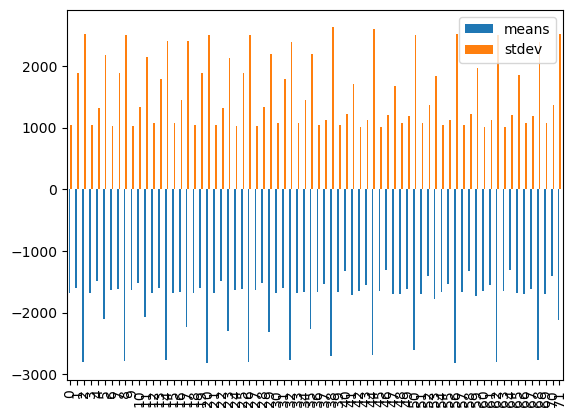

In [137]:
# ทำมาดูข้อมูลทั้งหมดเฉยๆ
df_all = pd.DataFrame(data=all_data)
df_all
df_all.plot.bar()

<AxesSubplot:>

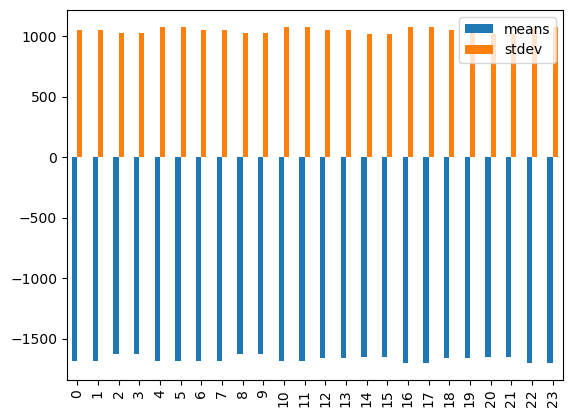

In [138]:
# Display Mean, std, params
# plot linear
data_linear
df_linear = pd.DataFrame(data=data_linear)
df_linear
df_linear.plot.bar()

<AxesSubplot:>

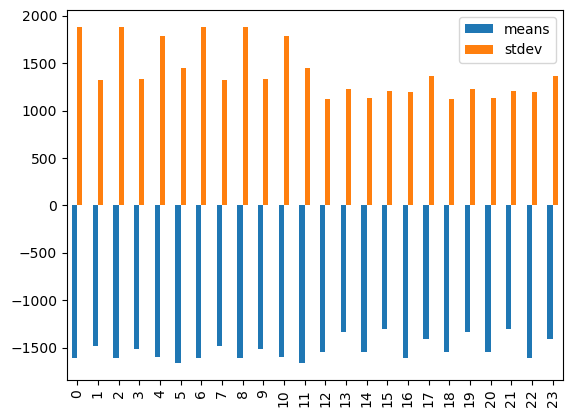

In [139]:
data_rbf
df_rbf = pd.DataFrame(data=data_rbf)
df_rbf.plot.bar()

<AxesSubplot:>

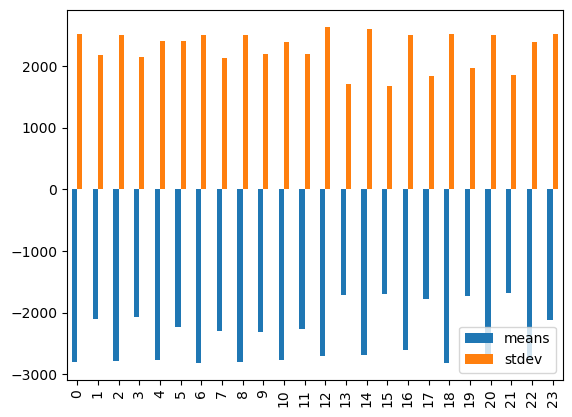

In [140]:
data_poly
df_poly = pd.DataFrame(data=data_poly)
df_poly.plot.bar()

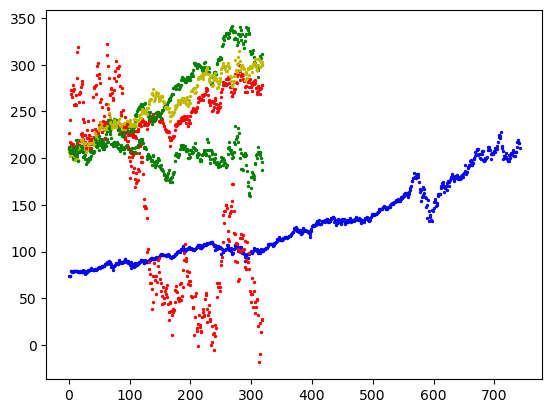

In [141]:
# Show scatter plot compare y_test vs each model prediction
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
SVR_Linear = svr_lin.fit(X_train,Y_train).predict(X_test)
SVR_Rbf = svr_rbf.fit(X_train,Y_train).predict(X_test)
SVR_Poly = svr_poly.fit(X_train,Y_train).predict(X_test)
plt.scatter(np.arange(len(y_test_pred_lr)),y_test_pred_lr, edgecolors='r', s=2)
plt.scatter(np.arange(len(Y_train)),Y_train, edgecolors='b', s=2)
plt.scatter(np.arange(len(Y_test)),Y_test, edgecolors='g', s=2)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear, edgecolors='y', s=2)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf, edgecolors='g', s=2)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly, edgecolors='r', s=2)
plt.show()


RandomizedSearchCV()

In [142]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

In [143]:
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [144]:
# Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = list(np.linspace(0.1, 150, 5, dtype = float))
ep_list = list(np.linspace(0.1, 1, 5, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 5, dtype = float))
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )


In [145]:
# GridSearchCV() -> (a) 
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR
    grid_rand = RandomizedSearchCV( estimator=model, n_jobs = 1, 
                                    verbose = 10,
                                    cv = 4,
                                    scoring = 'neg_mean_squared_error',
                                    param_distributions = params )
    grid_rand_result = grid_rand.fit(X_train, Y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/4; 1/4] END fit_intercept=True, normalize=True;, score=-482.118 total time=   0.0s
[CV 2/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/4; 1/4] END fit_intercept=True, normalize=True;, score=-774.971 total time=   0.0s
[CV 3/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 3/4; 1/4] END fit_intercept=True, normalize=True;, score=-1619.776 total time=   0.0s
[CV 4/4; 1/4] START fit_intercept=True, normalize=True..........................
[CV 4/4; 1/4] END fit_intercept=True, normalize=True;, score=-3384.415 total time=   0.0s
[CV 1/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/4; 2/4] END fit_intercept=True, normalize=False;, score=-482.118 total time=   0.0s
[CV 2/4; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/

In [146]:
# Show Best Parameters for both models
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 3, 'C': 75.05}
Best score:  -1263.5286076750979


In [147]:
# Show Score for each parameter combination for both model
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']
data_linear = []
data_rbf = []
data_poly = []
all_data = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    all_data.append({'means': mean, 'stdev': stdev})
    if param['kernel'] == 'linear':
        data_linear.append({'means': mean, 'stdev': stdev})
    elif param['kernel'] == 'rbf':
        data_rbf.append({'means': mean, 'stdev': stdev})
    elif param['kernel'] == 'poly':
        data_poly.append({'means': mean, 'stdev': stdev})

-2807.996892 (2511.766068) with: {'kernel': 'poly', 'gamma': 0.1, 'epsilon': 0.775, 'degree': 3, 'C': 0.1}
-1723.993253 (1941.628888) with: {'kernel': 'linear', 'gamma': 0.01, 'epsilon': 0.55, 'degree': 2, 'C': 0.1}
-2799.403139 (2500.126241) with: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 1.0, 'degree': 3, 'C': 150.0}
-2684.252589 (2479.435414) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.325, 'degree': 3, 'C': 0.1}
-1360.395420 (1250.462858) with: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C': 37.575}
-1277.098910 (1164.958390) with: {'kernel': 'rbf', 'gamma': 0.0775, 'epsilon': 0.775, 'degree': 3, 'C': 150.0}
-1782.234839 (1677.654518) with: {'kernel': 'poly', 'gamma': 0.0775, 'epsilon': 0.325, 'degree': 2, 'C': 37.575}
-1325.632829 (1155.692117) with: {'kernel': 'rbf', 'gamma': 0.0775, 'epsilon': 1.0, 'degree': 3, 'C': 37.575}
-1263.528608 (1054.794296) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 3, '

<AxesSubplot:>

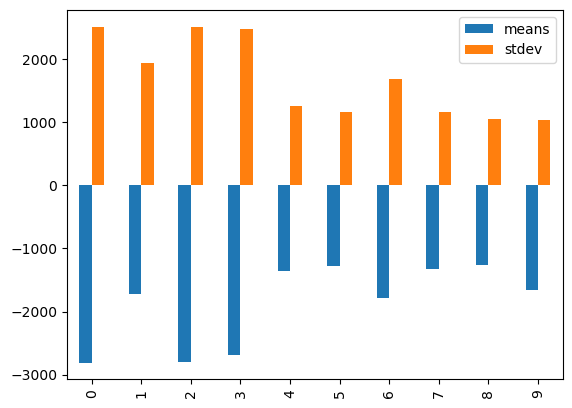

In [148]:
# ทำมาดูข้อมูลทั้งหมดเฉยๆ
df_all = pd.DataFrame(data=all_data)
df_all
df_all.plot.bar()

<AxesSubplot:>

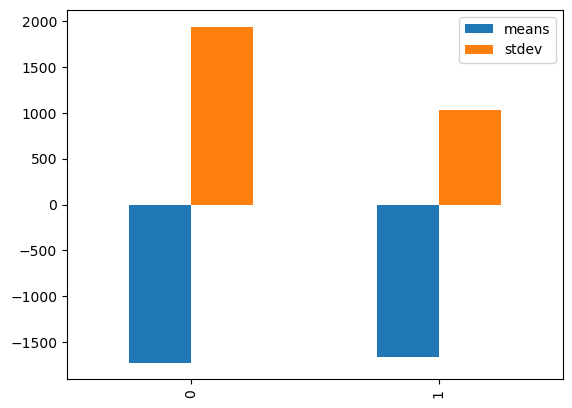

In [149]:
# Display Mean, std, params
# Bar()
data_linear
df_linear = pd.DataFrame(data=data_linear)
df_linear
df_linear.plot.bar()

<AxesSubplot:>

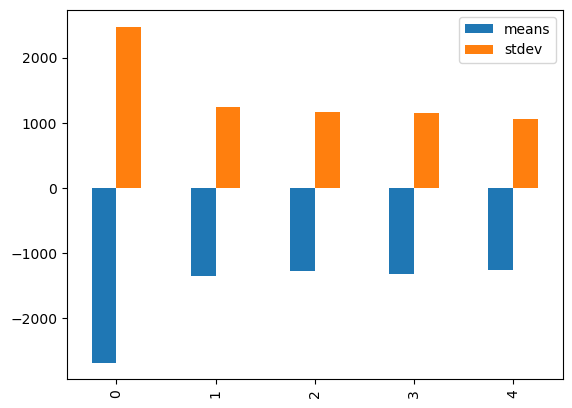

In [150]:
data_rbf
df_rbf = pd.DataFrame(data=data_rbf)
df_rbf
df_rbf.plot.bar()

<AxesSubplot:>

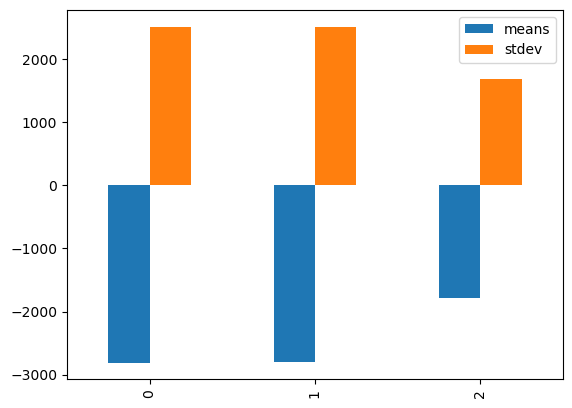

In [151]:
data_poly
df_poly = pd.DataFrame(data=data_poly)
df_poly
df_poly.plot.bar()

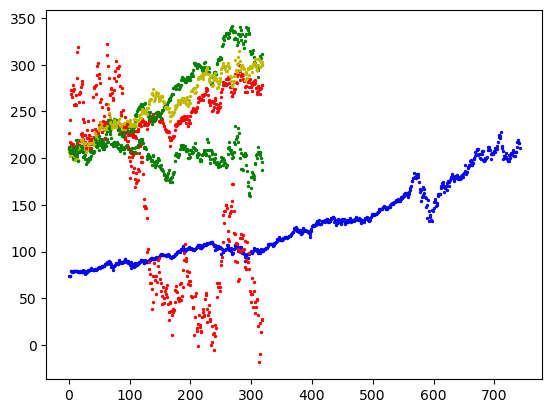

In [152]:
# Show scatter plot compare y_test vs each model prediction
# plt.scatter()
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
SVR_Linear = svr_lin.fit(X_train,Y_train).predict(X_test)
SVR_Rbf = svr_rbf.fit(X_train,Y_train).predict(X_test)
SVR_Poly = svr_poly.fit(X_train,Y_train).predict(X_test)
plt.scatter(np.arange(len(y_test_pred_lr)),y_test_pred_lr, edgecolors='r', s=2)
plt.scatter(np.arange(len(Y_train)),Y_train, edgecolors='b', s=2)
plt.scatter(np.arange(len(Y_test)),Y_test, edgecolors='g', s=2)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear, edgecolors='y', s=2)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf, edgecolors='g', s=2)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly, edgecolors='r', s=2)
plt.show()
# โชว์ข้างบนไปแล้วอันนี้ไม่ต้องทำ